# <center>Digital Image Processing - Problem Set 6</center>

### Student Names:

### Problem 1

Write a function that performs image recognition using <b>your own implementation</b> of $k$-Nearest Neighbors ($k$-NN). You can (and are encouraged to) use the functions you have written for previous exercises. Your function should run the following steps:

#### 1. Create dataset

For this semester we are going to implement an improved version for image classification of the Sillicon Valley's Hot Dog or Not app

In [1]:
from IPython.display import HTML
from IPython.display import YouTubeVideo

# HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/ACmydtFDTGs?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')


- Pick 1 for each of the following food types = [junk, dessert, sea, vegetarian, beverages].
- Create two folders: **training_set** and **testing_set**
- For each selected food, pick at least 10 different images and store 7 in training folder. The rest must be stored in the testing one.
- Resize all images to a fixed resolution. Delete the previously saved images in order to preserve space. 
- If any image pre-processing is necessary, please do.

Repeat all steps for all food images.

**Example images.**
<p>Junk</p>
<img style="float: left; margin: 0px 0px 15px 15px;" src="files/hot_dog/hot_dog_1.jpeg" width="200" height="200">
<img style="float: left; margin: 0px 0px 15px 15px;" src="files/hot_dog/hot_dog_2.jpeg" width="200" height="200">
<img style="margin: 0px 0px 15px 15px;" src="files/hot_dog/hot_dog_3.jpeg" width="200" height="200"><br>

<p>Dessert</p>
<img style="float: left; margin: 0px 0px 15px 15px;" src="files/ice_cream/ice_cream_2.jpeg" width="150" height="150">
<img style="float: left; margin: 0px 0px 15px 15px;" src="files/ice_cream/ice_cream_3.jpeg" width="150" height="150">
<img style="margin:0px 0px 15px 15px;" src="files/ice_cream/ice_cream_1.jpeg" width="150" height="150"><br>


#### 2. Compute descriptors

- Describe each food in the training set.
- You are encouraged to select the most appropiate descriptor seen in class.
- Explain the reasons why you picked it. The result must be in one feature vector per image.
- Repeat previous steps for all images within the training set.

#### 3. Create classifier

The $k$-NN classifier predicts a category for each testing example according to the following steps:
- Pick an image from the testing set.
- Compute the distance from the feature vector associated to the testing example to all the descriptors from the training set.
- Select the closest $k$ training examples (that is, the $k$ training examples with shortest distance to our testing image).
- Find the category(food) associated to each of the $k$ training examples. This information is created by you in the training set.
- Assign a label to the testing image. The assigned label is equal to the most common label among the $k$ closes training examples.

#### 4. Perform experiments

Repeat this process for all testing examples. Compute the accuracy of the classifier in terms of the number of correctly classified testing examples over the total number of examples in the testing set. Compare the difference in performance between a 1-NN classifier, a 3-NN classifier and a $k$-NN classifier. Summarize the performance of each classifier using confusion matrices.

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import os

### Step 0: Preprocessing

In [4]:
# this code compare size 1 and size 2
# return false if dimentions are differents
# and if have diffenrents values
def compare_size(s1, s2):
    if len(s1) != len(s2):
        return False
    for i,j in zip(s1, s2):
        if i != j:
            return False
    return True

In [5]:
# preprocessig
# This function crop and resize code to set imae to specific dimentions
# if image have same dimentions, image is skiped
def preproc(image, size, color=255):
    h, w = image.shape[:2]
    ch = 0
    if len(image.shape) > 2:
        ch = image.shape[2]
    ratio_in = h / w
    ratio_out = size[0] / size[1]
    if ratio_in < ratio_out:
        new_h = w * size[1] // size[0]
        lim_h = (new_h - h) // 2
        if ch:
            temp_image = np.ones((new_h, w, ch), dtype=image.dtype) * color
        else:
            temp_image = np.ones((new_h, w), dtype=image.dtype) * color
        temp_image[lim_h:lim_h + h, 0:w] = image
    elif ratio_out < ratio_in:
        new_w = size[0] * h // size[1]
        lim_w = (new_w - w)//2
        if ch:
            temp_image = np.ones((h, new_w, ch), dtype=image.dtype) * color
        else:
            temp_image = np.ones((h, new_w), dtype=image.dtype) * color
        temp_image[0:h, lim_w: lim_w + w] = image
    else:
        temp_image = image
    return cv2.resize(temp_image, size)
    

In [6]:
# set size to process images
SIZE_DATASET = (360, 360)

In [7]:
# preprocessing all images from dataset
DATASET_DIR = 'files/dataset'
for r, d, files in os.walk(DATASET_DIR):
    for f in files:
        if (f[-4:] == '.jpg'):
            filename = os.path.join(r, f)
            image = cv2.imread(filename)
            if not compare_size(image.shape[:2], SIZE_DATASET):
                out_image = preproc(image, SIZE_DATASET)
                cv2.imwrite(filename, out_image)
print('finish')

finish


### Step 1: create descriptor

Abstract class is used to set methods that a descriptor must have

In [8]:
from abc import ABC

class BasicDescriptor(ABC):
    def __init__(self):
        self._keypoints = []
        self._descriptors = []
    def getFeatures(self, image):
        pass
    def getFeatures(self):
        return self._descriptors
    def displayFeatures(self, image):
        pass


In [9]:
# based on https://isotope11.com/blog/storing-surf-sift-orb-keypoints-using-opencv-in-python

# def pickle_keypoints(keypoints, descriptors):
#     temp_array = []
#     for i, point in enumerate(keypoints):
#         temp = [point.pt[0], point.pt[1], point.size, point.angle, point.response, point.octave,
#         point.class_id, descriptors[i]]
#         temp_array.append(np.array(temp, dtype=np.float32))
#     return temp_array

# def unpickle_keypoints(array):
#     keypoints = []
#     descriptors = []
#     for point in array:
#         temp_feature = cv2.KeyPoint(x=point[0],y=point[1],_size=point[2], _angle=point[3],
#                                     _response=point[4], _octave=point[5], _class_id=point[6])
#         temp_descriptor = point[7]
#         keypoints.append(temp_feature)
#         descriptors.append(temp_descriptor)
#     return keypoints, np.array(descriptors)

In [10]:
import random

VECTOR_FEATURES_SIZE = 64

def select_random(l1, l2, v = None): 
    if len(l1) != len(l2):
        raise Exception('LIST can be need the same len')
    if v == None:
        v = VECTOR_FEATURES_SIZE
    n = len(l1)
    index = []
    if  v < n:
        index = random.sample(range(n), v)
    elif v > n:
        index = list(range(n)) + random.sample(range(n), v - n)
    else:
        return l1, l2
    return [l1[i] for i in index], [l2[i] for i in index]

In [11]:
# this descriptor use extract all sift descriptors from image
# also is able to draw descriptor points on image

class SIFTDescriptor(BasicDescriptor):
    
    def calcFeatures(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        sift = cv2.xfeatures2d.SIFT_create()
        kp, des = sift.detectAndCompute(gray, None)
        self._keypoints, self._descriptors = select_random(kp, des)
        
    def displayFeatures(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return cv2.drawKeypoints(gray, self._keypoints, gray, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        

In [12]:
# this descriptor use extract all SURF descriptors from image
# also is able to draw descriptor points on image

class SURFDescriptor(BasicDescriptor):
    
    def calcFeatures(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        surf = cv2.xfeatures2d.SURF_create(400)
        kp, des = surf.detectAndCompute(gray, None)
        self._keypoints, self._descriptors = select_random(kp, des)
    
    def displayFeatures(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return cv2.drawKeypoints(gray, self._keypoints, gray, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    

In [13]:
# hu moments is another way to identify an image, so, 
# we use an HU descriptor to extrac Hu moments from image

class HUDescriptor(BasicDescriptor):
    
    def calcFeatures(self, image):
        img1 = cv2.medianBlur(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), 7)
        img_th = cv2.adaptiveThreshold(img1,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,255,2)
        kernel = np.ones((5,5),np.uint8)
        img2 = cv2.dilate(img_th,kernel,iterations = 1)
        self._descriptors = cv2.HuMoments(cv2.moments(img2)).flatten()
        self._img2 = img
    
    def displayFeatures(self, image):
        return self._img2
    

In [14]:
# ORB features are similar to SIFT and SURF but license is free

class ORBDescriptor(BasicDescriptor):
    
    def __init__(self):
        self._orb = cv2.ORB_create()
    
    def calcFeatures(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        kp = self._orb.detect(gray, None)
        kp, des = self._orb.compute(gray, kp)
        self._keypoints, self._descriptors = select_random(kp, des)

    def displayFeatures(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return cv.drawKeypoints(gray, self._keypoints, None, color=(0,255,0), flags=0)


### Step 2: create Classificator

In [15]:
# we use similar idea to create a classificator,
# we create a abstract class to define how
# classficator must be works
# a classificator can be able to train from features (x) and labes (y) 
# and predict a label (y) from x data

from abc import ABC

class BasicClassificator(ABC):
    def train(self, x, y):
        pass
    def pedict(self, x):
        pass

In [16]:
# this classificator was create to compute Hu moments

class KNNClassificator(BasicClassificator):
    
    def __init__(self, k=5):
        self._k_value = k
        self._knn = cv2.ml.KNearest_create()
        
    def train(self, x_array, y_array):
        self._knn.train(x_array, cv2.ml.ROW_SAMPLE, y_array)
        
    def predict(self, x, k=None):
        if k == None:
            _, results, neighbours, dist = self._knn.findNearest(x, self._k_value) 
            return results[0][0], np.dstack((neighbours, dist))[0]
        # this is a solution
        _, results, neighbours, dist = self._knn.findNearest(x, k) 
        return results[0][0]

In [17]:
from scipy import stats

# this classificator is used to predict label using SIFT, SURF and ORB

class KNNClassificatorBOG(KNNClassificator):
        
    def predict(self, x, k=None):
        results = None
        neighbours = None
        dist = None
        if k == None:
            _, results, neighbours, dist = self._knn.findNearest(x, self._k_value)
        else:
            _, results, neighbours, dist = self._knn.findNearest(x, k) 
        return stats.mode(results)[0][0]

### Step 3: train

In [18]:
TRAINING_SET_DIR = DATASET_DIR + '/training_set'
classes = os.listdir(TRAINING_SET_DIR)
print(classes)

['broccoli', 'bread', 'pizza', 'hot_dog', 'potato', 'ice_cream']


In [19]:
knn_class = KNNClassificator(5)

In [20]:
k_values = [1, 3, 5]
nk = len(k_values)

broccoli


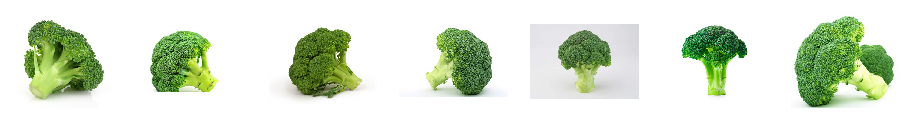

bread


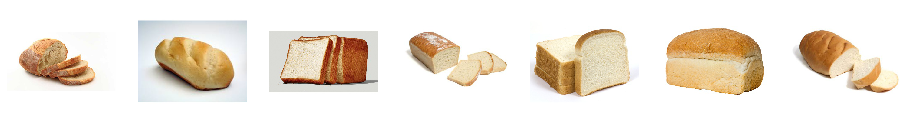

pizza


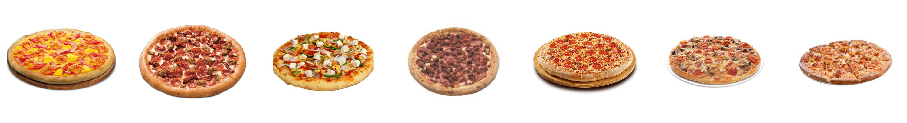

hot_dog


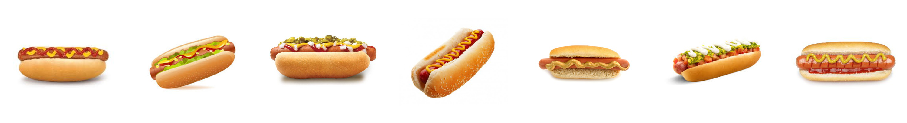

potato


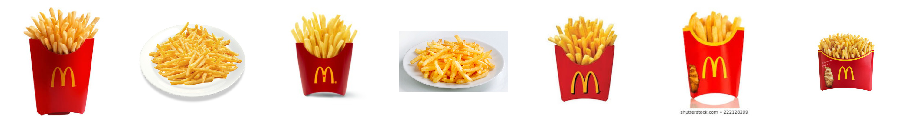

ice_cream


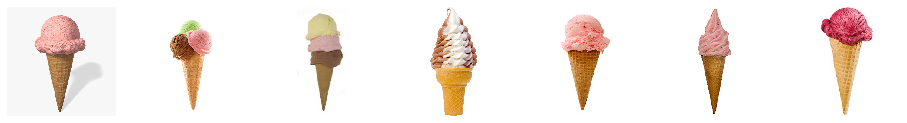

In [21]:
y = []
x = [] # hu moments

y_sift = []
x_sift = []

y_surf = []
x_surf = []

y_orb = []
x_orb = []

# sift_des = SIFTDescriptor()
descriptor = HUDescriptor()
sift_des = SIFTDescriptor()
surf_des = SURFDescriptor()
orb_des = ORBDescriptor()

# extract data from trainning dataset

for root, dirs, files in os.walk(TRAINING_SET_DIR):

    new_files = [item for item in files if item[-4:] == '.jpg' ]
    n_figures = len(new_files)
    
    if n_figures == 0:
        continue
    
    print(os.path.split(root)[1])
    plt.figure(figsize=(16, 8))
    
    for i,f in enumerate(new_files):
        # add label
        classname = os.path.split(root)[1]
        if not classname in classes:
            continue
        index_class = classes.index(classname)
        y.append(index_class)
        # add features
        img = cv2.imread(os.path.join(root, f))
        # add hu features
        descriptor.calcFeatures(img)
        kp = descriptor.getFeatures()
        x.append(kp)
        
        # add sift features
        sift_des.calcFeatures(img)
        sdes = sift_des.getFeatures()
        x_sift.extend(sdes) 
        y_sift.extend([index_class] * len(sdes))
        # add surf features
        surf_des.calcFeatures(img)
        sdes = surf_des.getFeatures()
        x_surf.extend(sdes) 
        y_surf.extend([index_class] * len(sdes))
        # add orb descriptor
        orb_des.calcFeatures(img)
        sdes = orb_des.getFeatures()
        x_orb.extend(sdes) 
        y_orb.extend([index_class] * len(sdes))
        
        plt.subplot(1, n_figures, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis(False)
        
    plt.show()
        
        
# convert to array to insert on knn classificator

x = np.asarray(x).astype(np.float32)
y = np.asarray(y).astype(np.float32)

x_sift = np.asarray(x_sift).astype(np.float32)
y_sift = np.asarray(y_sift).astype(np.float32)

x_surf = np.asarray(x_surf).astype(np.float32)
y_surf = np.asarray(y_surf).astype(np.float32)

x_orb = np.asarray(x_orb).astype(np.float32)
y_orb = np.asarray(y_orb).astype(np.float32)


In [22]:
knn_class.train(x, y) # train 

In [23]:
# train all 

knn_sift = KNNClassificatorBOG(5)
knn_sift.train(x_sift, y_sift)

knn_surf = KNNClassificatorBOG(5)
knn_surf.train(x_surf, y_surf)

knn_orb = KNNClassificatorBOG(5)
knn_orb.train(x_orb, y_orb)


### testing

broccoli


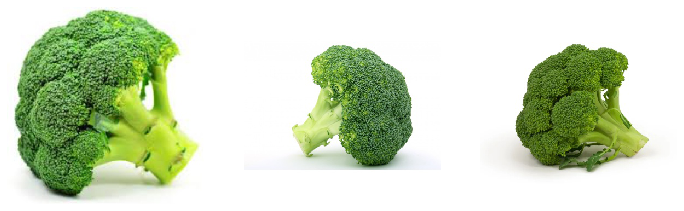

bread


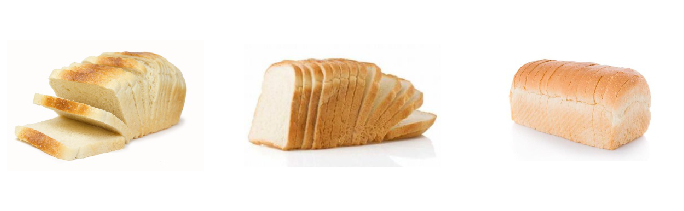

pizza


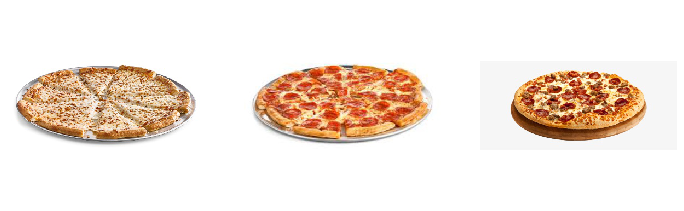

hot_dog


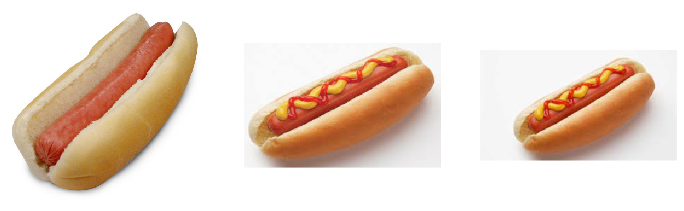

potato


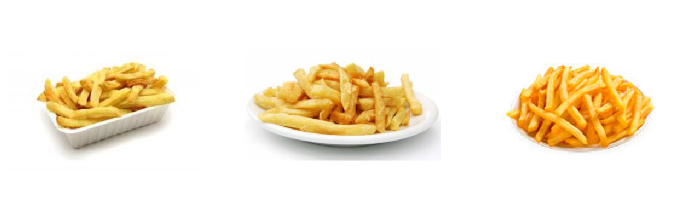

ice_cream


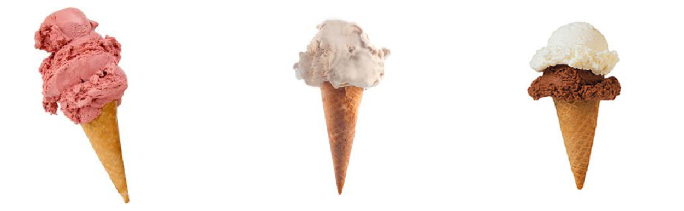

In [24]:
TESTING_SET_DIR = DATASET_DIR + '/testing_set'

y_test = []
y_predict = [[] for i in range(nk)]

y_predict_sift = [[] for i in range(nk)]
y_predict_surf = [[] for i in range(nk)]
y_predict_orb = [[] for i in range(nk)]


# we extract all feactures from all images 

for root, dirs, files in os.walk(TESTING_SET_DIR):
    
    new_files = [item for item in files if item[-4:] == '.jpg' ]
    n_figures = len(new_files)
    
    if n_figures == 0:
        continue
    
    print(os.path.split(root)[1])
    plt.figure(figsize=(12, 6))
    
    for index_image, f in enumerate(new_files):
        # add label
        classname = os.path.split(root)[1]
        if not classname in classes:
            continue
        index_class = classes.index(classname)
        y_test.append(index_class)
        # add features
        img = cv2.imread(os.path.join(root, f))
        descriptor.calcFeatures(img)

        # 
        sift_des.calcFeatures(img)
        surf_des.calcFeatures(img)
        orb_des.calcFeatures(img)
        
        for i, kval  in enumerate(k_values):

            x_test = np.asarray([descriptor.getFeatures()]).astype(np.float32)
            index_predicted = knn_class.predict(x_test, kval)
            index_predicted = int(index_predicted)
            y_predict[i].append(index_predicted)
            
            x_test = np.asarray(sift_des.getFeatures()).astype(np.float32)
            # print(x_test.shape)
            index_predicted = knn_sift.predict(x_test, kval)
            index_predicted = int(index_predicted)
            y_predict_sift[i].append(index_predicted)
            
            x_test = np.asarray(surf_des.getFeatures()).astype(np.float32)
            index_predicted = knn_surf.predict(x_test, kval)
            index_predicted = int(index_predicted)
            y_predict_surf[i].append(index_predicted)
            
            x_test = np.asarray(orb_des.getFeatures()).astype(np.float32)
            index_predicted = knn_orb.predict(x_test, kval)
            index_predicted = int(index_predicted)
            y_predict_orb[i].append(index_predicted)
            
        plt.subplot(1, n_figures, index_image + 1)
        plt.axis(False)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        

    plt.show()
            

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [26]:
print('for HU')
# measue accuracy from differents k values
for i, item in enumerate(k_values):
    print ("Accuracy for k = %d: %f" % (item, accuracy_score(y_test, y_predict[i])))  #Accuracy of the K-NN classifier
print()

for HU
Accuracy for k = 1: 0.388889
Accuracy for k = 3: 0.222222
Accuracy for k = 5: 0.277778



In [27]:
# accuracy form others classificators  must be meassured

print('for SIFT')
for i, item in enumerate(k_values):
    print ("Accuracy for k = %d: %f" % (item, accuracy_score(y_test, y_predict_sift[i])))
print()
    
print('for SURF')
for i, item in enumerate(k_values):
    print ("Accuracy for k = %d: %f" % (item, accuracy_score(y_test, y_predict_surf[i])))
print()

print('for ORB')
for i, item in enumerate(k_values):
    print ("Accuracy for k = %d: %f" % (item, accuracy_score(y_test, y_predict_orb[i])))
print()

for SIFT
Accuracy for k = 1: 0.611111
Accuracy for k = 3: 0.277778
Accuracy for k = 5: 0.333333

for SURF
Accuracy for k = 1: 0.500000
Accuracy for k = 3: 0.277778
Accuracy for k = 5: 0.333333

for ORB
Accuracy for k = 1: 0.500000
Accuracy for k = 3: 0.222222
Accuracy for k = 5: 0.388889



HU


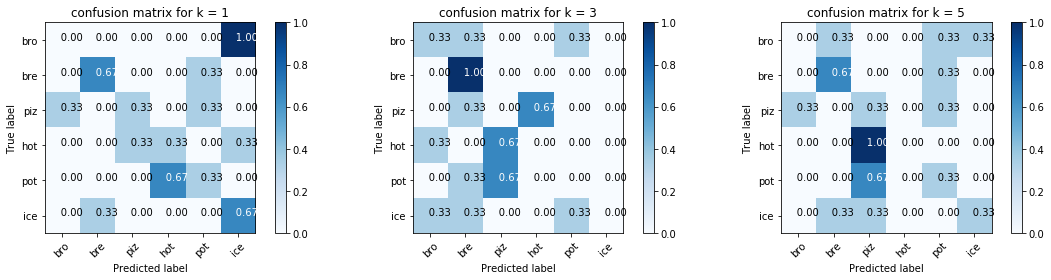


sift


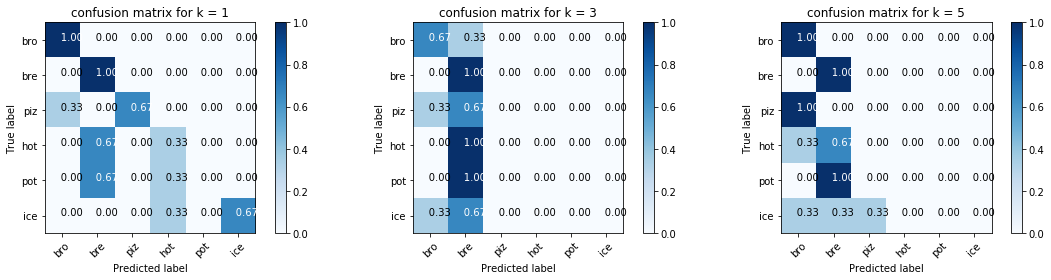


surf


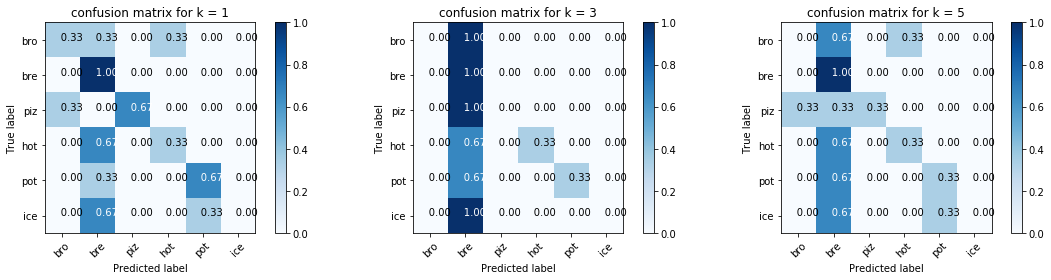


orb


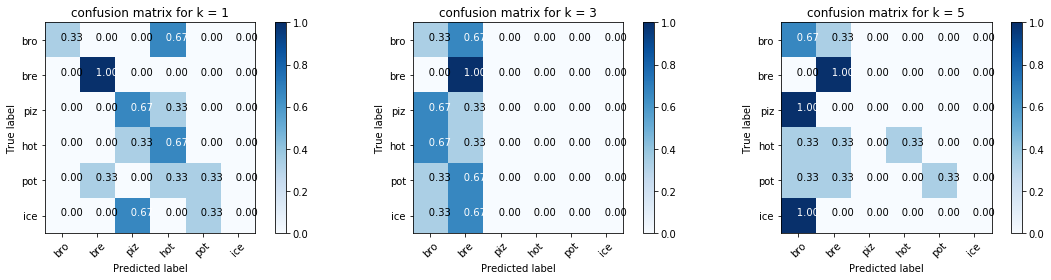

In [28]:
import itertools

# compute all results on confusion matrix, to get a graphic way to get data

predited_labels = [y_predict, y_predict_sift, y_predict_surf, y_predict_orb]
labes = ['HU', 'sift', 'surf', 'orb']

for i, list_predict in enumerate(predited_labels):
    
    print(labes[i])

    plt.figure(figsize=(16, 4))

    for i, kval in enumerate(k_values):

        conf_mat = confusion_matrix([classes[item][:3] for item in y_test],
                                    [classes[item][:3] for item in list_predict[i]])

        conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

        plt.subplot(1, 3, i + 1)
        plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('confusion matrix for k = ' + str(kval))
        plt.colorbar()
        tick_marks = range(len(classes))
        plt.xticks(tick_marks, [item[:3] for item in classes], rotation=45)
        plt.yticks(tick_marks, [item[:3] for item in classes])
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.axis([-0.5 , len(classes) -0.5, len(classes) - 0.5, -0.5])

        thresh = conf_mat.max() / 2.
        for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
            plt.text(j, i, "{:10.2f}".format(conf_mat[i, j]),
                     horizontalalignment="center",
                     color="white" if conf_mat[i, j] > thresh else "black")

    plt.show()
    
    print()

### Results: 

Accuracy Results depend on two factors: classificator and decriptor selected, unfortunally, we use only an Knn classifier. So, only we can contrast diffents **k** values. To get the best accuracy we need to select apropiate k value. If k is very small (nearest to 1) classificator is very overfited and we are going to result with high variability level. 

We need to select same number to descriptos because this avoid increasse posibility to fit classificator to class with higest number of descriptors. 

Descriptors have differents results:

- **Hu moments**, in contrast to other extractors, generates a small data per image and have a good accuracy. Accuracy can be low if try separate images from clases which have similar way. Example (hot-dog and bread) If shape are very differents, accuracy is increase.

- **SIFT** and **SURT** got a slow accuracy because classes can be share similars features. For example, *bread* class have similar descriptors to *hod-dog* class. If a class have a high variance on yours descriptos, knn classificator can be generate fake predicted values.

- **ORB** had better results for k = 1 and k = 5. But *bread* and *brocoli* descriptors absorb results because this class 